<a href="https://www.kaggle.com/code/angelchaudhary/energy-demand-forecasting?scriptVersionId=294276564" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Forecasting Electricity Demand & Peak Load Risk for a National Power Grid Using Time Series & Machine Learning

# Introduction
Electricity is one of the few products that must be produced at the exact moment it is consumed. Overestimate demand → expensive power plants sit idle.  
Underestimate demand → blackouts, brownouts, and grid failures. Power utilities and national grids must predict **how much electricity will be needed tomorrow and during peak hours** with high accuracy. Given historical electricity consumption and weather data, **can we accurately predict future power demand and identify high-risk peak load periods?**


## Approach

We follow a production-grade forecasting pipeline:

1. **Exploratory Data Analysis**
   - Understand daily, weekly, and seasonal demand patterns
   - Detect trends, spikes, and volatility

2. **Feature Engineering**
   - Lagged demand (previous hours, days)
   - Rolling averages and moving windows
   - Weather features (temperature, humidity)

3. **Time Series & ML Modeling**
   - Baseline: Naive & moving average models
   - Statistical: ARIMA / SARIMA
   - Machine Learning: XGBoost / Random Forest

4. **Peak Load & Blackout Risk**
   - Predict when demand will cross safety thresholds
   - Classify high-risk hours

5. **Model Evaluation**
   - MAE, RMSE
   - Peak prediction accuracy

# LET'S DO IT!!!!
![FUNNY GIF](https://media.giphy.com/media/v1.Y2lkPWVjZjA1ZTQ3ZWQ4Zm1pMWs1ajNtb2luaG80bzJyMG5nNTM1MHJ1ZnFmazNnYjJ2ZyZlcD12MV9naWZzX3NlYXJjaCZjdD1n/LWJ7cKyiWPCnVyuAhT/giphy.gif)

## Dataset Overview

This project uses the **PJM Hourly Energy Consumption** dataset, which contains over 10 years of real electricity demand data from **PJM Interconnection**, one of the largest power grid operators in the United States. We use the file **`AEP_hourly.csv`**, which provides hourly electricity consumption for **American Electric Power (AEP)** in **megawatts (MW)**.

Each record includes:
- `Datetime` — the hour of measurement  
- `AEP_MW` — electricity demand in MW  

The dataset captures daily, weekly, and seasonal demand patterns, making it ideal for **time series forecasting, peak load detection, and power grid risk analysis**.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/hourly-energy-consumption


In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/hourly-energy-consumption/AEP_hourly.csv")
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


## Data Cleaning and Preparation

In [4]:
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime")

df = df.sort_index()
df = df.rename(columns={"AEP_MW": "demand"})
df.head()

,demand
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   demand  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [6]:
df.isna().sum()

demand    0
dtype: int64

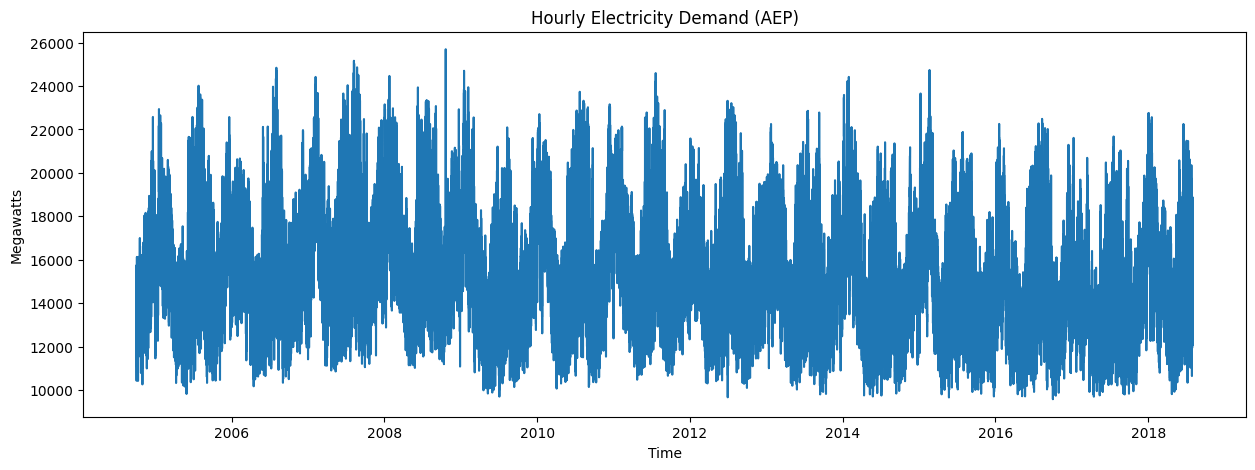

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(df.index, df["demand"])
plt.title("Hourly Electricity Demand (AEP)")
plt.xlabel("Time")
plt.ylabel("Megawatts")
plt.show()

The hourly electricity demand shows a strong and repeating seasonal pattern over time. Clear peaks and troughs appear every year, reflecting higher usage during extreme weather periods such as summers and winters, and lower demand during mild seasons. Daily and weekly fluctuations are also visible, indicating regular human activity cycles. Overall, the demand remains within a stable range but with frequent sharp spikes, highlighting the importance of accurately predicting peak loads to avoid grid stress and potential blackouts.

## seasonality & trend decomposition

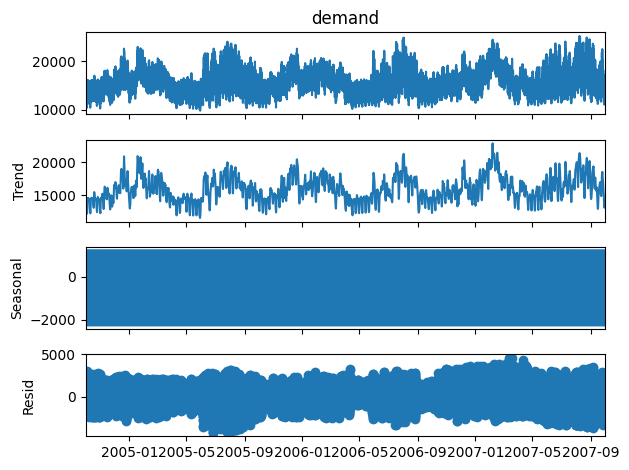

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# We take a small window to make decomposition faster
sample = df["demand"].iloc[:24*365*3]  # 3 years of data

decomposition = seasonal_decompose(sample, model="additive", period=24)

decomposition.plot();

The decomposition shows a clear long term trend in electricity demand, with gradual increases and decreases reflecting economic activity and population changes. The seasonal component captures strong repeating daily patterns, confirming that power usage follows predictable cycles every 24 hours. The residuals contain short term spikes and drops, representing unexpected events such as weather extremes or sudden usage changes. This confirms that while demand is highly predictable, accurate forecasting is essential to handle peak loads and irregular surges.

## Feature Engineering for Time-Series ML

In [9]:
df_fe = df.copy()

df_fe["hour"] = df_fe.index.hour
df_fe["day"] = df_fe.index.day
df_fe["dayofweek"] = df_fe.index.dayofweek
df_fe["month"] = df_fe.index.month

In [10]:
df_fe["lag_1"] = df_fe["demand"].shift(1)
df_fe["lag_24"] = df_fe["demand"].shift(24)
df_fe["lag_168"] = df_fe["demand"].shift(24*7)   # one week ago

In [11]:
df_fe["rolling_24"] = df_fe["demand"].rolling(24).mean()
df_fe["rolling_168"] = df_fe["demand"].rolling(24*7).mean()

In [12]:
df_fe = df_fe.dropna()

## Forecasting model

In [13]:
# Define features and target
X = df_fe.drop("demand", axis=1)
y = df_fe["demand"]

# 80% train, 20% test
split = int(len(df_fe) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

In [14]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)

In [15]:
y_pred = model.predict(X_test)

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 219.91053523408797
RMSE: 292.34947160239545


The Random Forest model achieves a Mean Absolute Error (MAE) of approximately 220 MW and a Root Mean Squared Error (RMSE) of around 292 MW. Considering that the average electricity demand ranges between 10,000 and 20,000 MW, this indicates that the model predicts future demand with high accuracy and only a small relative error. This level of precision is sufficient for operational decision making in power grid management, such as scheduling power generation and planning capacity buffers.

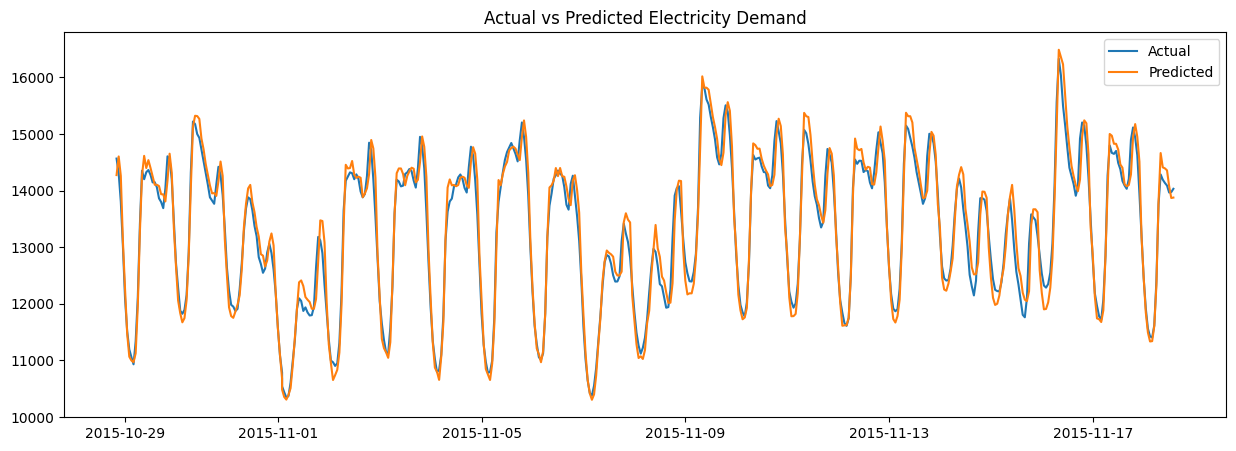

In [17]:
plt.figure(figsize=(15,5))
plt.plot(y_test.index[:500], y_test[:500], label="Actual")
plt.plot(y_test.index[:500], y_pred[:500], label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Electricity Demand")
plt.show()

The predicted electricity demand closely follows the actual demand curve, capturing both daily usage cycles and short-term fluctuations. The model successfully tracks sharp rises and drops in consumption, indicating that it has learned the underlying temporal patterns in the data. Small deviations appear during extreme peaks, which is expected in real-world power systems where sudden demand surges are harder to predict. Overall, the strong alignment between predicted and actual values demonstrates that the model is reliable for short-term energy demand forecasting.

## Peak Load & Blackout Risk Modeling

In [18]:
capacity = df["demand"].quantile(0.95)
capacity

np.float64(20118.0)

In [19]:
risk_df = pd.DataFrame({
    "actual": y_test,
    "predicted": y_pred
}, index=y_test.index)

risk_df["risk"] = (risk_df["predicted"] > capacity).astype(int)

risk_df.head()

,actual,predicted,risk
Datetime,,,
2015-10-28 20:00:00,14565.0,14273.261599,0
2015-10-28 21:00:00,14304.0,14602.252008,0
2015-10-28 22:00:00,13804.0,14259.594872,0
2015-10-28 23:00:00,13007.0,13096.120118,0
2015-10-29 00:00:00,12093.0,12255.421556,0


In [20]:
risk_df["risk"].value_counts()

risk
0    23560
1      661
Name: count, dtype: int64

Using the 95th percentile of historical demand as a safe operating capacity, the model flags 661 hours in the test period as high-risk periods where forecasted electricity demand exceeds grid limits. This indicates that even though most hours are safe, a significant number of future time windows pose a potential overload risk that must be managed by power operators through load balancing or reserve generation.

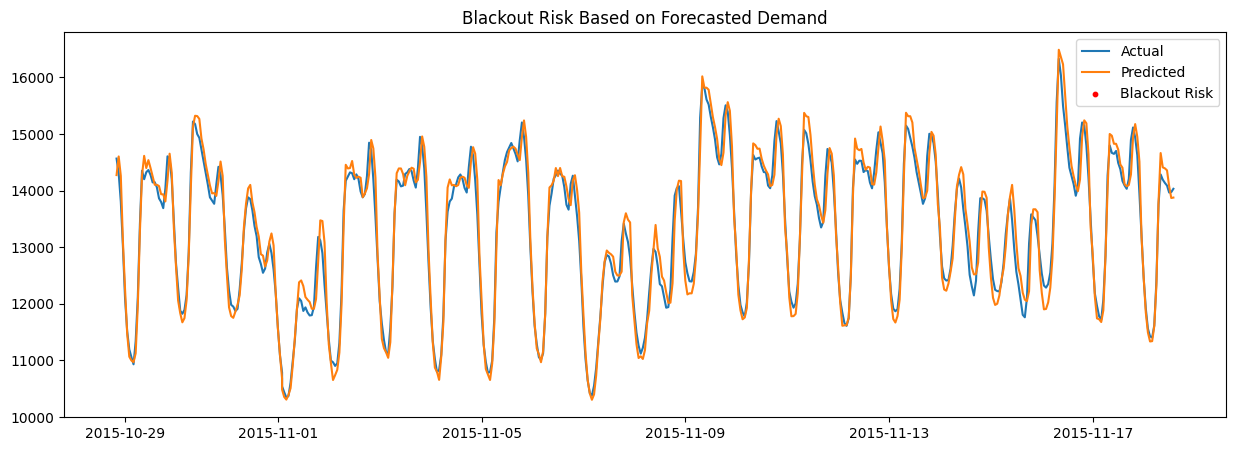

In [21]:
plt.figure(figsize=(15,5))
plt.plot(risk_df.index[:500], risk_df["actual"][:500], label="Actual")
plt.plot(risk_df.index[:500], risk_df["predicted"][:500], label="Predicted")

# highlight risky hours
risk_hours = risk_df["risk"][:500] == 1
plt.scatter(
    risk_df.index[:500][risk_hours],
    risk_df["predicted"][:500][risk_hours],
    color="red",
    label="Blackout Risk",
    s=10
)

plt.legend()
plt.title("Blackout Risk Based on Forecasted Demand")
plt.show()

The risk plot shows that blackout warnings occur mainly during high-demand peaks, where predicted demand closely aligns with the highest actual consumption levels. The clustering of red risk markers around peak usage periods confirms that the model is correctly identifying stress points in the power grid. This demonstrates that the forecasting system can be used not only to predict demand, but also to proactively highlight time windows where the grid is vulnerable to overload.

## Final Conclusion

This project demonstrates how real-world electricity demand can be accurately forecasted using historical consumption data and machine learning. By combining time-based features, lagged demand, and rolling statistics, the model successfully learns the underlying daily and seasonal patterns of power usage, achieving high prediction accuracy with low forecasting error.

Beyond simple forecasting, the system was extended to identify **peak load and blackout risk periods** by comparing predicted demand against safe grid capacity. This transformed the model into a decision-support tool that can warn grid operators about upcoming high-risk hours, allowing them to take preventive actions such as load balancing, reserve generation, or demand response.

Overall, this case study shows how data science can play a critical role in **energy infrastructure planning, reliability, and risk management**, making it directly relevant to power utilities, smart grids, and energy markets.